In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys, os
sys.path.append("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
os.chdir("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")

from utils.distributions import Categorical

In [2]:
path = os.getcwd() + "/pilot3-data/dataclips_cifnrkyusmfzozrjxaylwlrwxmfv.json"

data = json.load(open(path))

high_risk_clicks = [8, 23, 38, 53]
COST = 10
high_risk_click_reward = -1500 * 0.1
meta_expected_scores = [65, 45, 60, 45, 60]
hierarchical_expected_scores =  [75, 55, -1460, 55, 70]

In [3]:
def get_expected_score(trialdata, COST=COST):
    path = trialdata["path"]
    queries = trialdata["queries"]["click"]["state"]["target"]
    # Replace first element with 0 for root
    ground_truth =  [0] + trialdata["stateRewards"][1:]
    reward = 0
    #print(path)
    #print(high_risk_clicks)
    for node in path:
        if node in queries:
            reward += ground_truth[int(node)]
        else:
            if (node in high_risk_clicks) or (int(node) in high_risk_clicks):
                reward += high_risk_click_reward #Probability of triggering high risk event * negative reward of high risk event
            else:
                reward += 0 # Depends on experiment, in this case the expectation of all other nodes is 0
    # Click cost
    reward -= len(queries) * COST
    return reward

In [4]:
df_index = ["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "TestEnv", "HighRiskClicks"]
df_data = []

bonus_data = {}
known_workers = []
good_responses = 0

# Parse raw mturk data into dataframe
for p_index, p_data in enumerate(data["values"]):
    # Filter out empty responses
    response_data = p_data[-1]
    if response_data != None:
        p_res_obj = json.loads(response_data)
        condition = p_res_obj["condition"]
        # Obfuscate worker ID for publishing
        worker = p_index #p_res_obj["workerId"]
        if worker in known_workers:
            print("Duplicate worker", worker)
        else: 
            known_workers.append(worker)
        p_res = p_res_obj["data"]
        # Filter our incomplete trials
        # Get last instruction index
        # Test trials start after the last instruction
        # Index of that in the experiment is variable due to repeated instructions/quiz
        instruction_index = 0
        for i in range(len(p_res)):
            #print(p_res[i]["trialdata"]["trial_type"])
            if p_res[i]["trialdata"]["trial_type"] == "instructions":
                instruction_index = i+1
        #print(instruction_index)
        if len(p_res) > instruction_index + 5 and (instruction_index>14):
            good_responses += 1
            for i in range(instruction_index,instruction_index+5):
                trial = p_res[i]
                trialdata = trial["trialdata"]
                assert trialdata["trial_type"] == "mouselab-mdp"
                trialid = trialdata["trial_id"]
                queries = trialdata["queries"]["click"]["state"]["target"]
                path = trialdata["path"]
                score = trialdata["score"]
                trial_id = int(trialdata["trial_id"])
                expected_score = get_expected_score(trialdata)
                num_risk_clicks = sum([1 for el in high_risk_clicks if str(el) in queries])
                df_data.append([worker, condition, trialid, score, expected_score, len(queries), trial_id, num_risk_clicks])
        else:
            pass
            #if instruction_index > 14:
            #    print([p_res[i]["trialdata"]["trial_type"] for i in range(len(p_res))])
        try:
            bonus_data[worker] = max(p_res_obj["questiondata"]["final_bonus"], 0.2)
        except:
            bonus_data[worker] = 0.2
            pass
            #print("Uncompleted but usable trial for worker", worker)

print("Good responses", good_responses)
df = pd.DataFrame(df_data, columns=df_index)

Good responses 199


In [6]:
# Exclude participants with 0 clicks
participants = pd.DataFrame(df[df["NumClicks"] == 0].groupby("Participant").count()["NumClicks"])
excluded = list(participants[participants["NumClicks"]>2].index)
print("Exlcuded participants", excluded)
print("Total excluded", len(excluded))

Exlcuded participants [11, 27, 29, 35, 57, 67, 74, 80, 92, 101, 103, 105, 119, 120, 124, 130, 135, 150, 155, 157, 168, 170, 180, 203, 205, 242, 251, 255, 260, 275]
Total excluded 30


In [7]:
df_after_exclusion = df[~df["Participant"].isin(excluded)]
df_after_exclusion.to_csv(os.getcwd() + "/pilot3-data/main_excluded.csv")
len(df_after_exclusion)

845

In [8]:
print("Total", len(df_after_exclusion["Participant"].unique()))
df_after_exclusion.groupby(["Condition", "Participant"]).count()["TrialId"].reset_index().groupby("Condition").count()

Total 169


,Participant,TrialId
Condition,,
0,42,42
1,45,45
2,39,39
3,43,43


In [9]:
print("Average bonus:", np.round(np.mean(list(bonus_data.values())),2))
print("Minimum bonus:", np.round(np.min(list(bonus_data.values())),2))
print("Maximum bonus:", np.round(np.max(list(bonus_data.values())),2))
print("Summed bonues", np.sum(list(bonus_data.values())))
print("\n")
for participant, bonus in bonus_data.items():
    if bonus > 0:
        print(f"{participant}, {bonus}")

Average bonus: 0.32
Minimum bonus: 0.2
Maximum bonus: 1.0
Summed bonues 70.05000000000003


0, 0.2
4, 0.2
7, 0.2
8, 0.2
9, 0.2
11, 0.2
12, 0.2
13, 0.2
14, 0.2
16, 0.2
18, 0.6
19, 0.2
20, 0.2
22, 0.2
23, 0.2
24, 0.2
25, 0.98
26, 0.2
27, 0.2
28, 0.2
29, 0.67
30, 0.2
31, 0.67
32, 0.2
34, 0.2
35, 0.2
36, 0.2
37, 0.2
39, 0.69
41, 1
44, 0.24
45, 0.2
46, 0.2
47, 0.2
48, 0.2
49, 1
50, 0.2
51, 0.84
52, 0.2
53, 0.2
54, 0.2
55, 0.2
56, 0.2
57, 0.2
58, 0.2
59, 0.2
60, 0.2
62, 0.38
63, 0.2
64, 0.2
65, 0.2
66, 1
67, 1
68, 1
69, 0.2
70, 0.2
72, 0.2
73, 0.2
74, 0.64
76, 0.84
77, 0.2
78, 0.2
79, 0.2
80, 0.2
81, 0.2
82, 0.2
83, 0.2
84, 0.2
85, 0.2
86, 0.56
87, 0.2
88, 0.2
89, 0.2
90, 0.2
92, 0.2
94, 0.64
95, 0.2
96, 0.2
97, 0.2
98, 0.2
99, 0.2
100, 0.2
101, 0.2
103, 0.2
104, 0.2
105, 0.2
106, 0.2
109, 0.2
110, 0.2
111, 0.2
112, 1
113, 0.71
115, 0.2
116, 0.2
117, 0.87
119, 0.2
120, 0.2
121, 0.2
122, 0.2
123, 0.36
124, 1
125, 0.6
126, 1
127, 0.2
128, 0.2
129, 0.2
130, 0.2
131, 0.2
132, 0.2
133, 0.2
134, 0

### Basic statistics of the data (rest in R)

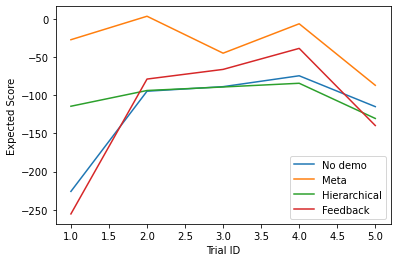

In [10]:
# Plot of scores per condition

score_per_trial = df_after_exclusion.groupby(["Condition", "TrialId"]).mean()[["Score", "ExpectedScore"]]
score_per_trial = score_per_trial.reset_index()


plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==0], label="No demo")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==1], label="Meta")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==2], label="Hierarchical")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==3], label="Feedback")
plt.xlabel("Trial ID")
plt.ylabel("Expected Score")
plt.legend()

In [11]:
df_after_exclusion.groupby("Condition").mean()[["ExpectedScore", "HighRiskClicks", "NumClicks"]]

,ExpectedScore,HighRiskClicks,NumClicks
Condition,,,
0,-119.738095,0.852381,7.671429
1,-32.266667,1.124444,3.933333
2,-102.358974,0.210256,3.682051
3,-115.697674,2.386047,14.023256


In [12]:
df_after_exclusion.groupby("Condition").std()["ExpectedScore"]

Condition
0    177.517579
1    126.013640
2     57.638890
3    181.357747
Name: ExpectedScore, dtype: float64

In [13]:
df_after_exclusion.groupby(["Condition"]).mean()["Score"]

Condition
0   -217.404762
1    -98.911111
2   -343.692308
3   -187.255814
Name: Score, dtype: float64

In [14]:
# Compare actual scores on trial 3
trial3 = df_after_exclusion[df_after_exclusion["TrialId"] == 3]

c1 = list(trial3[trial3["Condition"] == 1]["Score"])
c2 = list(trial3[trial3["Condition"] == 2]["Score"])

from scipy import stats

stats.ranksums(c1,c2)

RanksumsResult(statistic=0.4036036763977875, pvalue=0.6865041817875919)

In [15]:
print(np.mean(c1), np.std(c1))

print(np.mean(c2), np.std(c2))

print(np.std(c1+c2))

-136.33333333333334 522.8356444535043
-478.5897435897436 739.1418696600468
655.1566991594567
